# Doppler Shift

We take $v_{out} = 25$ km/s with $v_{rot} = 0$ km/s. Then we Doppler shift it to reproduce $v_{out} = 25$ km/s with $v_{rot} = 50$ km/s

This is an example:

![example](../../paper/figures/rotation_doppler_outflow.png)

Ly$\alpha$ scattering through an optically thick gas cloud that is undergoing solid-body rotation (i.e. in which the angular speed around the rotation axis is identical for each hydrogen atom) proceeds identical as in a static cloud. In order to compute the spectrum emerging from a rotating cloud, we sum the spectra emerging from all surface elements of the cloud, weighted by their intensity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rc('text', usetex=True)
plt.rc('font', size=20)

In [17]:
# Values

tau = 100000
vrot = 0
vrot_new = 50
vout = 25

In [18]:
#Reading data

fname = '../../data/tau10E5/vrot'+str(vrot)+'/vout'+str(vout)+'/tau10E5_vrot'+str(vrot)+'_vout'+str(vout)+'_out.ascii'
df = pd.read_csv(fname, delimiter=' ', dtype='float64')
        
escaped = df['escaped']
x = df['x']
y = df['y']
z = df['z']
z_u = df['z_u']
x_frec = df['x_frec']

inds = np.where(escaped == 0)[0]

x_escaped = np.array(x)[inds]
y_escaped = np.array(y)[inds]
z_escaped = np.array(z)[inds]
z_u_escaped = np.array(z_u)[inds]
x_frec_escaped = np.array(x_frec)[inds]

In [19]:
num_thetas = 9
cos_thetas = np.linspace(0,1,num_thetas+1) 
cos_thetas_plus = np.linspace(-1,0,num_thetas+1) 

thetas = np.sort(np.array([np.arccos(ct) for ct in cos_thetas]))
thetas_plus = np.array([np.arccos(ctp) for ctp in cos_thetas_plus])

In [23]:
# unitary vectors in the x, y, z directions

distance = np.sqrt(x_escaped**2 + y_escaped**2 + z_escaped**2)
x_unitary = x_escaped/distance
y_unitary = y_escaped/distance
z_unitary = z_escaped/distance

In [32]:
# atom velocities

v_x = x_unitary*vout - y_unitary*vrot_new
v_y = y_unitary*vout + x_unitary*vrot_new
v_z = z_unitary*vout

In [33]:
# shift factor

num_photons = len(x_frec_escaped)
shift_factors = np.zeros(num_photons)

for i in range(num_photons):
    r_unitary = np.array([x_unitary[i], y_unitary[i], z_unitary[i]])
    velocity_vector = np.array([v_x[i], v_y[i], v_z[i]])
    
    shift_factors[i] = np.dot(velocity_vector, r_unitary)

In [40]:
v_th = -12.8

theta_lower = thetas[-2]
theta_upper = thetas[-1]
theta_plus_lower = thetas_plus[-1]
theta_plus_upper = thetas_plus[-2]


fig = plt.figure(1, (10., 6.))

props = dict(boxstyle='square', facecolor='white')

acos_z_u_escaped = np.array([np.arccos(zu) for zu in z_u_escaped])
angle_indices = np.where( ((acos_z_u_escaped >= theta_lower) & (acos_z_u_escaped < theta_upper)) | ((acos_z_u_escaped >= theta_plus_lower) & (acos_z_u_escaped < theta_plus_upper)))[0]

current_x = x_frec_escaped[angle_indices] #only the ones between those upper and lower angles
current_shift_factors = shift_factors[angle_indices]
current_x_vel_shifted = current_x*v_th + current_shift_factors

vrot_lab = r'${0:.0f}$'.format(vrot_new)
vout_lab = r'${0:.0f}$'.format(vout)
theta_lower_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_lower)))
theta_upper_lab = r'${0:.0f}$'.format(int(np.rad2deg(theta_upper)))

theta_lab = r'$\theta=$ '
lab = '$v_{rot}=$ '+vrot_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$\n $v_{out}=$ '+vout_lab+' $\mathrm{km}$ $\mathrm{s^{-1}}$'

n, b = np.histogram(current_x_vel_shifted, bins=40)        
delta_x = b[1]-b[0]
area = delta_x * sum(n)
n = n/area

border_x = []
border_y = []

for j in range(len(n)-1):
    border_x.append(b[j]+delta_x/2)
    border_x.append(b[j]+delta_x/2)
    border_y.append(n[j])
    border_y.append(n[j+1])

plt.bar(b[0:40], n, width=delta_x, color='c', edgecolor=None, alpha = 1)
plt.plot(border_x, border_y, c='k', linewidth=1)

plt.axvline(x=0, ymin=0, ymax=1, c='k', linestyle='--', linewidth=1)
plt.xlim(-200,250)
plt.ylim(0,0.013)
plt.ylabel('$\mathrm{Intensity}$')
plt.xlabel('$\mathrm{V}$ ($\mathrm{km}$ $\mathrm{s^{-1}}$)')
plt.text(-180,0.011, lab, fontsize=20, bbox=props)

plt.savefig('doppler_shift_shifted.png', format='png', transparent=False, bbox_inches='tight')
plt.close()

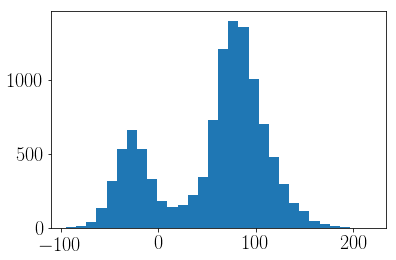

In [42]:
plt.hist(current_x_vel_shifted, bins=30)
plt.show()